In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
# reflect points who get "dry" by streaming representing boundaries. e.g if you are at the bottom, reflect 4 to 2, i.e. f[2, 1, ] = f[4, 0, ]
# that is overwriting the streaming step
NX = 300
NY = 300
w_i = np.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])# weights, note that the last four (edges) 
# are the interpolation points with the highest velocity; weights influence probability density
c_ij = np.array([[0, 1,  0, -1, 0, 1, -1, -1, 1], [0, 0, 1, 0, -1, 1, 1, -1, -1]])# velocities x and y component

In [20]:
# global density function
f_inm = np.einsum('i,jk -> ijk', w_i, np.ones((NX + 2, NY + 2)))# product of two arrays
f_inm[:, 0, :] = 0
f_inm[:, NX+1, :] = 0
f_inm[:, :, 0] = 0
f_inm[:, :, NY + 1] = 0
      
# extended density function with sourrounding for dry nodes

In [4]:
def dens_lattice_point(f_vxy):
    return np.einsum('vxy -> xy', f_vxy)

def vel_field_lattice_point(f_vxy):
    rho = dens_lattice_point(f_vxy)
    v = np.einsum('ij, ixy -> jxy', c_ij.T, f_vxy)
    return v / rho

def stream(f_ijk):
    # define a velocity vector containing all shifting directions
    c_ij = [[0, 0],[0, 1],[-1, 0],[0, -1], [1, 0], [-1, 1], [-1, -1], [1, -1], [1, 1]]
    for p in range(1,9):
        f_ijk[p] = np.roll(f_ijk[p], shift=c_ij[p], axis=(0,1))
    return f_ijk

In [5]:
f_eq_vxy = np.zeros((9, NX+2, NY+2)) # reshape?

# equilibrium and collision operater
def equi_dist(rho, av_vel):
    u_abs = np.einsum('inm, inm -> nm',abs(av_vel),abs(av_vel))
    for j in range(9):
        scal = np.einsum('j, jnm -> nm', c_ij.T[j], av_vel)
        f_eq_vxy[j] = w_i[j] * rho *(1 + 3*scal + 9/2*scal**2- 3/2 * u_abs)
    return f_eq_vxy

def comp_new_dist(f_vxy, f_eq, omega = 1):
    f_vxy += omega * (f_eq - f_vxy)
    # omega describes the impact of the relaxation
    return f_vxy

In [12]:
# for the sliding lid we implement a moving wall for the top boundary and three rigid walls for the other boundaries

# moving wall
def moving_wall(vel):
    # calculate the values from Mohamad, used for the simulation of the moving wall
    rho_N = f_inm[0, 1, 1:NY+1] + f_inm[1, 1, 1:NY+1] + f_inm[3, 1, 1:NY+1]  + 2 * (f_inm[2, 1, 1:NY+1] + f_inm[6, 1, 1:NY+1] + f_inm[5, 1, 1:NY+1])
    f_inm[4, 1, :] = f_inm[2, 0, :]
    # velocity of moving wall
    u_N = vel

    f_inm[7, 1, 1:NY+1] = f_inm[5, 0, 2:NY+2]
    f_inm[7, 1, 1:NY+1] += 1/2 * (f_inm[1, 1, 1:NY+1] - f_inm[3, 1, 1:NY+1]) - 1/2 * rho_N * u_N
    f_inm[8, 1, 1:NY+1] = f_inm[6, 0, 0:NY]
    f_inm[8, 1, 1:NY+1] += 1/2 * (f_inm[3, 1, 1:NY+1] - f_inm[1, 1, 1:NY+1]) + 1/2 * rho_N * u_N
    # set dry nodes to zero
    f_inm[2, 0, :] = 0
    f_inm[5, 0, :] = 0
    f_inm[6, 0, :] = 0

In [7]:
# rigid walls
def bounce_back_south():
    # bottom boundary implemented as hard wall, reflecting the streaming impulses; this has to happen after the streaming step
    f_inm[2, NX, :] = f_inm[4, NX+1, :]

    # northeast bounce back from left down corner to right down corner of wet nodes
    f_inm[5, NX, 1:NY+1] = f_inm[7, NX+1, 0:NY]
    # northwest bounce back
    f_inm[6, NX, 1:NY+1] = f_inm[8, NX+1, 2:NY+2]
    # set dry nodes back to zero so they do not influence streaming
    f_inm[7, NX+1, :] = 0
    f_inm[8, NX+1, :] = 0
    f_inm[4, NX+1, :] = 0

def bounce_back_west():
    f_inm[1, :, 1] = f_inm[3, :, 0]
    
    # northeast bounce back from left down corner to left upper corner
    f_inm[5, 1:NX+1, 1] = f_inm[7, 2:NX+2, 0] 
    # southeast bounce back
    f_inm[8, 1:NX+1, 1] = f_inm[6, 0:NX, 0]
    
    # set dry nodes to zero
    f_inm[7, :, 0] = 0
    f_inm[6, :, 0] = 0
    f_inm[3, :, 0] = 0
    
def bounce_back_east():
    f_inm[3, :, NY] = f_inm[1, :, NY+1]
    
    # southwest bounce back
    f_inm[6, 1:NX+1, NY] = f_inm[8, 2:NX+2, NY+1]
    # northwest bounce back
    f_inm[7, 1:NX+1, NY] = f_inm[5, 0:NX, NY+1]
    
    # set dry nodes to zero
    f_inm[8, 2:NX+2, NY+1] = 0
    f_inm[5, 0:NX, NY+1] = 0
    f_inm[1, :, NY+1] = 0

In [8]:
# TODO: Think about the order of the functions calls of the walls for the simulation: what happens in the corners 
# of the wet node grid?
# Intuition: Do moving wall first to bounce back the modified data
# Still: how to do bounce back in the southern corners? Average over both values

In [9]:
# Reynolds number calculation: Leaving system lenght L = 300 and viscosity of water nhy= 10^-6 m^2/s,
# modifying the velocity of the moving wall
# return the velocity of the moving wall with constant Re
L = NY
nü = 10**(-6)
Re = 1000
def comp_vel_moving_wall(Re, L):
    return (Re * nü) / L

In [10]:
# Reynolds number calculation with viscosity depending on relaxation time tau
# returns the relaxation time with constant Re
L = NY
cs_2 = 1/3
#nhy = cs_2 * ((1/omega) - 1/2)
Re = 1000
def comp_relaxation_time(Re, L, u_mv):
    return 1/((Re * L * u_mv * 3) + 0.5)

In [13]:
# simulation sliding lid, 
rho = np.ones((NX+2, NY+2))
#rho[:,:] = 1
u = np.zeros((2,NX+2, NY+2))

f_inm_eq = equi_dist(rho, u)

for i in range(10):
    f_inm = comp_new_dist(f_inm, f_inm_eq, omega = 0.2)

    f_inm = stream(f_inm)
    # now do moving wall before bounce backs, we assume that in the upper corner the values from the bounce back
    # and the moving wall influence are the same (as f1 - f3 = 0)
    moving_wall(comp_vel_moving_wall(500, 300))
    bounce_back_west()
    bounce_back_south()
    bounce_back_east()
    rho = dens_lattice_point(f_inm)
    
    u = vel_field_lattice_point(f_inm)

    f_inm_eq = equi_dist(rho, u)

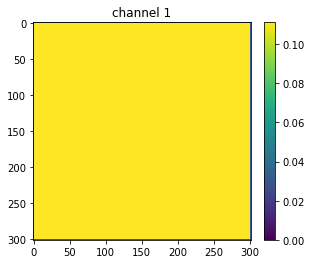

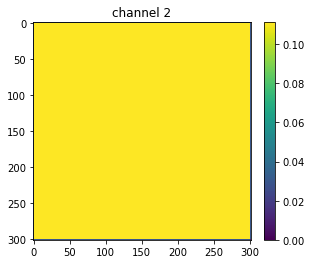

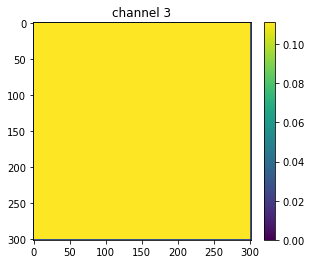

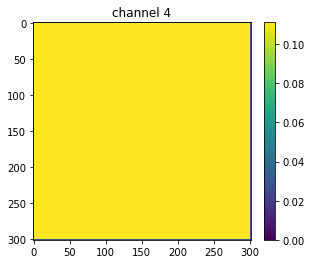

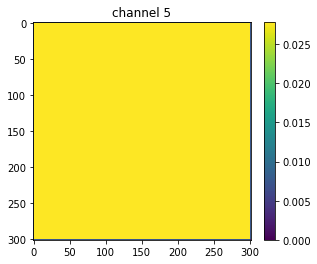

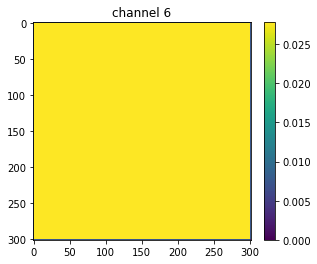

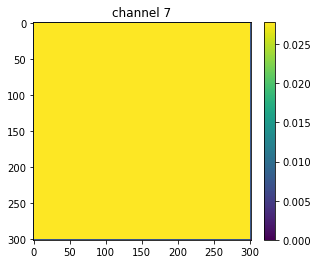

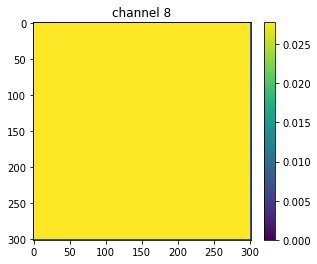

In [23]:
# check for the channels what the simulation produced 
for i in range(8):
    fig, ax = plt.subplots()
    im = ax.imshow(f_inm[i+1])
    plt.title("channel " + str(i+1))
    plt.colorbar(im,fraction=0.046, pad=0.04)
    plt.show()

In [18]:
def plot_velocity(f, c=None, v=None, return_plot=False, fix_dims=True):
    """ Plot the averagae velocity of the distribution f.
    
    Args:
        f: probability distribution
        
    Optional:
        c: Directions of D2Q9-scheme
        v: velocity for each channel if already computed so we avoid computing it again. Otherwise computed as sum over channels times c
        return_plot: If True, return the axis-Object to plot it or change it in other file
        fix_dims: If True: To keep plots coherent, invert x-axis and change x and y-axis
    """
    
    if c is None:
        c = np.array([[0, 0], [0, 1], [-1, 0], [0, -1], [1, 0], [-1, 1], [-1, -1], [1, -1], [1, 1]])
    if fix_dims:
        c = np.stack([c[:,1], -c[:,0]], axis=1) 
    if v is None:
        v = np.einsum('cij, cd -> dij', f, c)
        
    ax = plt.subplot()
    x, y = np.meshgrid(np.arange(f.shape[1]), np.arange(f.shape[2]))
    ax.quiver(x,y, v[0,...], v[1,...], angles='xy', scale_units='xy', scale=1, color='b', label='Vector Field')
    ax.grid()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('equal')
    ax.set_xlim(-2, f.shape[1]+1)
    ax.set_ylim(-2, f.shape[2]+1)
    ax.set_title("Velocity field")
    
    
    #plot the edges
    ax.plot(np.arange(-1,x.shape[1]+1), np.ones(x.shape[1]+2)*(-1), 'k')
    ax.plot(np.arange(-1,x.shape[1]+1), np.ones(x.shape[1]+2)*(x.shape[0]), 'k')
    
    ax.plot(np.ones(x.shape[0]+2)*(-1), np.arange(-1,x.shape[0]+1), 'k')
    ax.plot(np.ones(x.shape[0]+2)*(x.shape[1]), np.arange(-1,x.shape[0]+1), 'k')
    
    if return_plot:
        return ax
    else:
        plt.show()

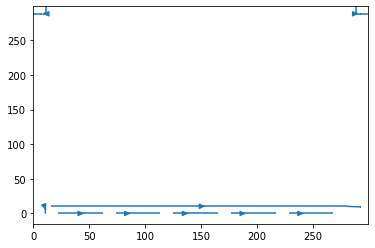

In [24]:
# Streamplot simulations
#u = vel_field_lattice_point(f_inm)

#np.meshgrid(NX, NY)
Y, X = np.mgrid[0:NX, 0:NY]
#Y = np.arange(NY)
#U = -1 - X**2 + Y
#V = 1 + X - Y**2
#plt.streamplot(X, Y, U, V, density=[1,1])

plt.streamplot(X, Y, u[0,1:NX+1, 1:NY+1], u[1,1:NX+1, 1:NY+1 ], density=[1,1])
plt.show()

In [19]:
# sad
# https://matplotlib.org/stable/gallery/images_contours_and_fields/plot_streamplot.html#sphx-glr-gallery-images-contours-and-fields-plot-streamplot-py

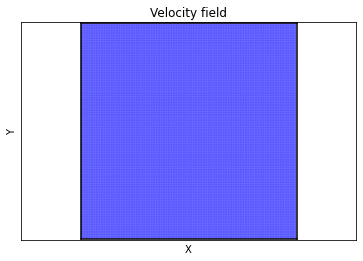

In [19]:
plot_velocity(f_inm)
plt.show()